In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [2]:
import copy
from pathlib import Path
import warnings

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [3]:
from utils import process_ETF_price_data

BB_candles = 60
data, test_data = process_ETF_price_data('SPY', SMA_five_min_candles=15, BB_five_min_candles=BB_candles, num_std=2)

data.sample(10, random_state=521)

100%|███████████████████████████████| 38667/38667 [00:00<00:00, 4586052.28it/s]


,time,open,high,low,close,volume,typical price,market_open,market_close,vwap,UVXY typical price,UVXY volume,15 candle SMA,60 candle SMA,60 candle STD,upper band,lower band,time_idx,group_id
87717,2020-05-11 11:45:00,284.343429,284.353172,284.197292,284.265490,854558.0,284.271985,,,283.453713,354.566667,6012.0,283.789471,283.866067,0.507436,284.880940,282.851194,2522,0
91524,2020-04-13 14:30:00,266.466016,266.602410,265.939923,266.550678,803522.0,266.364337,,,266.749898,497.033333,6354.0,266.531152,266.643324,0.923150,268.489624,264.797023,995,0
62548,2020-11-16 11:05:00,355.614032,355.722109,355.493869,355.697546,477942.0,355.637842,,,354.541209,125.630000,31633.0,354.788371,352.127399,1.862008,355.851414,348.403384,12810,0
62686,2020-11-13 15:30:00,351.153382,351.521828,351.133731,351.457964,894739.0,351.371174,,,350.120974,128.532000,30471.0,351.114474,350.280692,0.654425,351.589541,348.971843,12785,0
14901,2021-11-18 12:40:00,468.117220,468.177008,467.878070,467.982698,291324.0,468.012592,,,466.464566,15.146333,429583.0,467.592949,466.694782,0.757997,468.210776,465.178788,32575,0
30485,2021-07-23 11:00:00,435.340133,435.409660,435.300403,435.349966,518995.0,435.353343,,,434.517156,28.170000,162249.0,434.612890,432.936411,1.135246,435.206903,430.665918,26081,0
80250,2020-07-07 10:55:00,309.557234,310.105227,309.557234,310.085655,885740.0,309.916039,,,309.274705,298.116667,28361.0,309.588498,309.480394,0.355352,310.191098,308.769690,5554,0
21709,2021-09-29 13:00:00,433.669580,433.858908,433.430430,433.460324,435181.0,433.583221,,,434.046386,24.226667,321820.0,433.532016,433.957169,0.737410,435.431989,432.482350,29771,0
53079,2021-02-01 10:45:00,368.236652,368.976697,367.980103,368.700413,878170.0,368.552404,,,368.028636,142.395667,128071.0,368.055261,366.419674,1.310681,369.041036,363.798312,16718,0
34766,2021-06-21 12:15:00,417.248140,417.332566,417.173646,417.272971,231920.0,417.259728,,,415.851316,32.370000,134478.0,417.221726,415.097976,1.664731,418.427439,411.768514,24302,0


In [5]:
max_prediction_length = 12
max_encoder_length = 300
training_cutoff = data['time_idx'].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx = 'time_idx',
    target = '15 candle SMA',
    group_ids=['group_id'],
    min_encoder_length = 0,
    max_encoder_length = max_encoder_length,
    max_prediction_length = max_prediction_length,
    static_categoricals = [],
    static_reals = [],
    time_varying_known_categoricals = ['market_open', 'market_close'],
    variable_groups = {},
    time_varying_known_reals = ['time_idx'],
    time_varying_unknown_categoricals = [],
    time_varying_unknown_reals = [
        'open',
        'high',
        'low',
        'close',
        'volume',
        'vwap',
        'UVXY typical price',
        'UVXY volume',
        '15 candle SMA',
        str(BB_candles) + ' candle SMA',
        str(BB_candles) + ' candle STD',
        'upper band',
        'lower band'
    ],
    add_relative_time_idx = True,
    add_target_scales = True,
    add_encoder_length = True
)

#Create Validation Set
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [6]:
#Baseline absolute mean error
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

0.0793253555893898

In [7]:
#Configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(gpus=1, gradient_clip_val=0.1)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 28.5k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|███████████████| 100/100 [00:28<00:00,  3.53it/s]


suggested learning rate: 0.09332543007969905


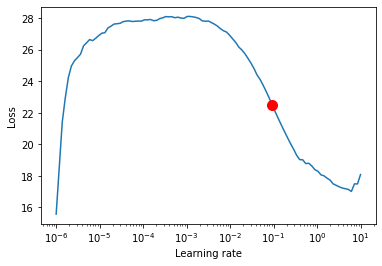

In [8]:
#Find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr = 1e-6
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [13]:
#configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("stonk_net_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=300,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=9,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 28.5k


In [14]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 4     
3  | prescalers                         | ModuleDict                      | 288   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 11.2 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.4 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Epoch 0:  97%|▉| 30/31 [00:08<00:00,  3.43it/s, loss=12.3, v_num=4, train_loss_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 31/31 [00:09<00:00,  3.36it/s, loss=12.3, v_num=4, train_loss_
Epoch 1:  97%|▉| 30/31 [00:18<00:00,  1.66it/s, loss=5.97, v_num=4, train_loss_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 31/31 [00:18<00:00,  1.68it/s, loss=5.97, v_num=4, train_loss_
Epoch 2:  97%|▉| 30/31 [00:27<00:00,  1.10it/s, loss=2.88, v_num=4, train_loss_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 31/31 [00:27<00:00,  1.12it/s, loss=2.88, v_num=4, train_loss_
Epoch 3:  97%|▉| 30/31 [00:36<00:01,  1.21s/it, loss=2.29, v_num=4, train_loss_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it

Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 57: 100%|█| 31/31 [08:59<00:00, 17.39s/it, loss=0.246, v_num=4, train_los
Epoch 58:  97%|▉| 30/31 [09:07<00:18, 18.26s/it, loss=0.243, v_num=4, train_los
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 58: 100%|█| 31/31 [09:08<00:00, 17.69s/it, loss=0.243, v_num=4, train_los
Epoch 59:  97%|▉| 30/31 [09:17<00:18, 18.57s/it, loss=0.228, v_num=4, train_los
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 59: 100%|█| 31/31 [09:17<00:00, 17.99s/it, loss=0.228, v_num=4, train_los
Epoch 60:  97%|▉| 30/31 [09:26<00:18, 18.88s/it, loss=0.238, v_num=4, train_los
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 60: 100%|█| 31/31 [09:26<00:00, 18.28s/it, loss=0.238, v_num=4, train_los
Epoch 61:  97%|▉| 30/31 [09

Epoch 115:  97%|▉| 30/31 [17:50<00:35, 35.70s/it, loss=0.197, v_num=4, train_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 115: 100%|█| 31/31 [17:53<00:00, 34.64s/it, loss=0.197, v_num=4, train_lo
Epoch 116:  97%|▉| 30/31 [18:02<00:36, 36.08s/it, loss=0.2, v_num=4, train_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 116: 100%|█| 31/31 [18:02<00:00, 34.93s/it, loss=0.2, v_num=4, train_loss
Epoch 117:  97%|▉| 30/31 [18:11<00:36, 36.37s/it, loss=0.199, v_num=4, train_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 117: 100%|█| 31/31 [18:11<00:00, 35.21s/it, loss=0.199, v_num=4, train_lo
Epoch 118:  97%|▉| 30/31 [18:19<00:36, 36.66s/it, loss=0.199, v_num=4, train_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it

Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 172: 100%|█| 31/31 [26:20<00:00, 50.99s/it, loss=0.199, v_num=4, train_lo
Epoch 173:  97%|▉| 30/31 [26:29<00:52, 52.98s/it, loss=0.205, v_num=4, train_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 173: 100%|█| 31/31 [26:29<00:00, 51.29s/it, loss=0.205, v_num=4, train_lo
Epoch 174:  97%|▉| 30/31 [26:38<00:53, 53.27s/it, loss=0.201, v_num=4, train_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 174: 100%|█| 31/31 [26:38<00:00, 51.57s/it, loss=0.201, v_num=4, train_lo
Epoch 175:  97%|▉| 30/31 [26:47<00:53, 53.57s/it, loss=0.192, v_num=4, train_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 175: 100%|█| 31/31 [26:47<00:00, 51.86s/it, loss=0.192, v_num=4, train_lo
Epoch 176:  97%|▉| 30/31 [2

Epoch 230:  97%|▉| 30/31 [34:56<01:09, 69.90s/it, loss=0.205, v_num=4, train_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 230: 100%|█| 31/31 [34:57<00:00, 67.66s/it, loss=0.205, v_num=4, train_lo
Epoch 231:  97%|▉| 30/31 [35:05<01:10, 70.19s/it, loss=0.204, v_num=4, train_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 231: 100%|█| 31/31 [35:06<00:00, 67.95s/it, loss=0.204, v_num=4, train_lo
Epoch 232:  97%|▉| 30/31 [35:14<01:10, 70.49s/it, loss=0.203, v_num=4, train_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 232: 100%|█| 31/31 [35:15<00:00, 68.23s/it, loss=0.203, v_num=4, train_lo
Epoch 233:  97%|▉| 30/31 [35:23<01:10, 70.78s/it, loss=0.196, v_num=4, train_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it

Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 287: 100%|█| 31/31 [43:28<00:00, 84.13s/it, loss=0.199, v_num=4, train_lo
Epoch 288:  97%|▉| 30/31 [43:36<01:27, 87.21s/it, loss=0.198, v_num=4, train_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 288: 100%|█| 31/31 [43:36<00:00, 84.42s/it, loss=0.198, v_num=4, train_lo
Epoch 289:  97%|▉| 30/31 [43:45<01:27, 87.51s/it, loss=0.196, v_num=4, train_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 289: 100%|█| 31/31 [43:45<00:00, 84.70s/it, loss=0.196, v_num=4, train_lo
Epoch 290:  97%|▉| 30/31 [43:54<01:27, 87.81s/it, loss=0.195, v_num=4, train_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/1 [00:00<?, ?it/s]
Epoch 290: 100%|█| 31/31 [43:54<00:00, 84.99s/it, loss=0.195, v_num=4, train_lo
Epoch 291:  97%|▉| 30/31 [4

In [ ]:
'''Hyperparamter tuning with [optuna](https://optuna.org/) is directly build into pytorch-forecasting. For example, we can use the 
:py:func:`~pytorch_forecasting.models.temporal_fusion_transformer.tuning.optimize_hyperparameters` function to optimize the TFT's hyperparameters.

.. code-block:: python
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)
'''

In [15]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [16]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.4038)

In [17]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(type(raw_predictions))
#print(raw_predictions)
print(raw_predictions['prediction'])

<class 'pytorch_forecasting.utils.TupleOutputMixIn.to_network_output.<locals>.Output'>
tensor([[[473.7264, 474.6487, 475.0902, 475.7758, 477.1530, 477.3568, 478.1815,
          340.3640, 340.9550],
         [474.0531, 474.7108, 475.2081, 475.9415, 477.0216, 477.4692, 478.4048,
          340.3414, 341.0533],
         [474.0723, 474.6804, 475.1515, 475.9797, 476.9218, 477.5280, 478.5496,
          340.4035, 340.9810],
         [474.0472, 474.6335, 475.0883, 475.9793, 476.8427, 477.5626, 478.6466,
          340.4528, 340.9232],
         [474.0203, 474.5960, 475.0399, 475.9727, 476.7853, 477.5898, 478.7193,
          340.4818, 340.8839],
         [474.0034, 474.5730, 475.0080, 475.9705, 476.7484, 477.6154, 478.7777,
          340.4938, 340.8593],
         [473.9975, 474.5620, 474.9894, 475.9738, 476.7265, 477.6401, 478.8264,
          340.4948, 340.8451],
         [474.0005, 474.5596, 474.9803, 475.9817, 476.7152, 477.6639, 478.8678,
          340.4890, 340.8376],
         [474.0097, 474.5

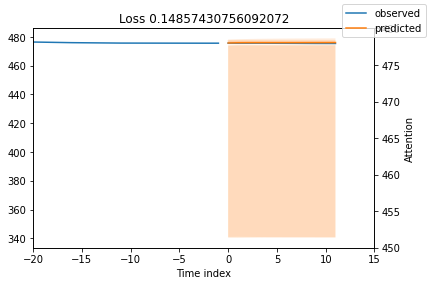

In [18]:
fig = best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);
plt.xlim(-20, 15)
plt.ylim(450, 480)
plt.show()

In [19]:
new_raw_predictions, new = best_tft.predict(test_data, mode="raw", return_x=True)
quant = new_raw_predictions['prediction']
print(quant)
print(test_data)

tensor([[[448.8072, 449.3611, 450.4752, 450.4258, 451.3403, 453.0852, 455.0265,
          342.3066, 344.8819],
         [442.9908, 444.0150, 445.0788, 445.0611, 446.3068, 447.7447, 449.9100,
          343.6606, 345.1110],
         [441.1224, 442.3161, 443.3708, 443.5004, 444.8617, 446.1469, 448.2547,
          344.3561, 344.9935],
         [440.3351, 441.5965, 442.6544, 442.8761, 444.2896, 445.4733, 447.4964,
          344.7657, 344.8766],
         [439.8873, 441.1807, 442.2435, 442.5225, 443.9733, 445.0677, 447.0132,
          345.0534, 344.7788],
         [439.5515, 440.8689, 441.9320, 442.2510, 443.7361, 444.7459, 446.6288,
          345.2802, 344.6912],
         [439.2541, 440.5963, 441.6546, 442.0037, 443.5228, 444.4534, 446.2886,
          345.4720, 344.6086],
         [438.9724, 440.3419, 441.3918, 441.7645, 443.3171, 444.1751, 445.9755,
          345.6401, 344.5298],
         [438.7037, 440.1025, 441.1415, 441.5330, 443.1177, 443.9107, 445.6867,
          345.7892, 344.4553],
 